In [1]:
import pandas as pd
import ydata_profiling

import shap
from catboost import Pool, CatBoostClassifier, cv

from sklearn.model_selection import train_test_split
import sklearn.metrics as m
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import optuna

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(2)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk


In [5]:
df.columns = df.columns.str.replace('(.)([A-Z].)', r'\1_\2', regex=True).str.lower()
df.head(2)

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk


In [6]:
# мб пригодится именно так..)
label_dict = {'low risk': '0',
              'mid risk': '1',
              'high risk':'2'}

df['risk_level'] = df['risk_level'].map(lambda x: label_dict.get(x))

## EDA

In [7]:
# закомментировано для гита, очень много места ест.
# ydata_profiling.ProfileReport(df)

HeartRate явно выделяется аномалия.   
Много дублей  
Остальное все ок, в целом

Для heart_rate можно удалить, но у нас и так не сильно много получается, после удаления дублей. Допустим, что опечатка и забыли дописать ноль.

In [8]:
df.loc[df['heart_rate'] == 7, 'heart_rate'] = 70

In [9]:
df = df.drop_duplicates()

## Предварительная оценка и подбор фичей на коте.

In [10]:
def fast_cat(data: pd.DataFrame, sh: bool = True, param: dict = {}) -> None:
    
    train, valid = train_test_split(data, test_size=0.2, random_state=42, stratify=data['risk_level'])

    train_pool = Pool(train.drop('risk_level', axis=1), 
                     train['risk_level'],
                     cat_features=cat_features)

    valid_pool = Pool(valid.drop('risk_level', axis=1), 
                     valid['risk_level'],
                     cat_features=cat_features)

    if param:
        model = CatBoostClassifier(**param)
    else:
        model = CatBoostClassifier(random_state=42, 
                                   ignored_features=['age'],
                                   verbose=1000, 
                                   eval_metric='Accuracy', 
                                   l2_leaf_reg=10, 
                                   eta=0.02, 
                                   iterations=2000)
    
    model.fit(train_pool, eval_set=valid_pool, plot=True)
    
    print(m.classification_report(valid['risk_level'], model.predict(valid_pool)))
    display(model.get_feature_importance(prettified=True))
    
    if sh:
        shap_test = shap.TreeExplainer(model).shap_values(valid_pool)
        shap.summary_plot(shap_test, valid_pool, feature_names=valid_pool.get_feature_names())    

In [11]:
cat_features = ['heart_rate', 'age_qcut']

In [12]:
df['age_qcut'] = pd.qcut(df['age'], 4, labels=False)

In [13]:
#df['bp_qcut'] = pd.qcut(df['systolic_bp'], 3, labels=False) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7506925	test: 0.7142857	best: 0.7142857 (0)	total: 54.6ms	remaining: 1m 49s
1000:	learn: 0.8337950	test: 0.7252747	best: 0.7472527 (359)	total: 2.1s	remaining: 2.09s
1999:	learn: 0.9390582	test: 0.7142857	best: 0.7472527 (359)	total: 4.37s	remaining: 0us

bestTest = 0.7472527473
bestIteration = 359

Shrink model to first 360 iterations.
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        47
           1       0.75      0.14      0.24        21
           2       0.82      0.78      0.80        23

    accuracy                           0.75        91
   macro avg       0.76      0.64      0.63        91
weighted avg       0.75      0.75      0.69        91



,Feature Id,Importances
0,bs,39.822017
1,systolic_bp,19.256396
2,body_temp,14.567247
3,heart_rate,11.507390
4,age_qcut,11.286337
5,diastolic_bp,3.560613
6,age,0.000000


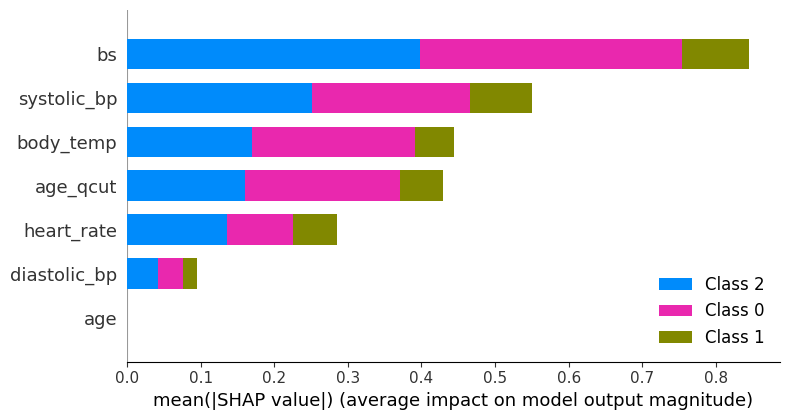

In [14]:
fast_cat(df)

Добавление возраста в виде бинов отрабатывает чуть лучше. Экспериментально выбрано 4 бина.

heart_rate чуть лучше отрабатывает, как категория

В теории, давление можно так же ставить "норма/высокое/низкое". На текущих данных качество будет немного хуже,  но не критично. Но в реальной модели человеку может быть проще указывать именно так.

Даже базовая модель достаточно неплохо работает с высоким риском, нормальные показатели prec/rec. С малым риском тоже.  
Возможно, для продакшн модели будет иметь смысл вообще убрать "средний" риск и делать бинарную, средний раскидать по соседним на основе модели. Врачу достаточно predict_proba

In [34]:
fast_cat(df[df['risk_level'] != '1'], sh=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9275362	test: 0.9142857	best: 0.9142857 (0)	total: 5.85ms	remaining: 11.7s
1000:	learn: 0.9927536	test: 0.9142857	best: 0.9428571 (317)	total: 1.85s	remaining: 1.85s
1999:	learn: 1.0000000	test: 0.9142857	best: 0.9428571 (317)	total: 3.94s	remaining: 0us

bestTest = 0.9428571429
bestIteration = 317

Shrink model to first 318 iterations.
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        47
           2       1.00      0.83      0.90        23

    accuracy                           0.94        70
   macro avg       0.96      0.91      0.93        70
weighted avg       0.95      0.94      0.94        70



,Feature Id,Importances
0,bs,35.823382
1,systolic_bp,23.801142
2,body_temp,15.990191
3,heart_rate,10.192731
4,age_qcut,9.224982
5,diastolic_bp,4.967571
6,age,0.000000


Бинарная показывает вполне неплохо. 

## Несколько моделей

In [16]:
num_features = ['systolic_bp', 'diastolic_bp', 'bs', 'body_temp']

In [17]:
ohe = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['age_qcut']),
                              (StandardScaler(), num_features))
                              
ode = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['age_qcut']),
                              (StandardScaler(), num_features))

**CatBoost** Оптуна отдельно. 

In [18]:
X = df.drop(['risk_level','age'], axis=1)
y = df['risk_level']

In [35]:
cat_param = {'learning_rate': 0.061313287195057235,
             'l2_leaf_reg': 2.0,
             'min_data_in_leaf': 264,
             'depth': 10,
             'grow_policy': 'Depthwise',
             'bootstrap_type': 'Bernoulli',
             'subsample': 0.9541959638914235,
             'leaf_estimation_method':'Newton',
             'iterations':1000,
             'random_state':1114,
             'eval_metric':'Accuracy',
             'early_stopping_rounds':500,
             'verbose':1000,
             'loss_function':'MultiClass'   
            }

In [20]:
df_pool = Pool(X, y, cat_features=cat_features)

In [36]:
cv_data = cv(
    params = cat_param,
    pool = df_pool,
    fold_count = 6,
    shuffle = True,
    partition_random_seed = 42,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/6]

bestTest = 0.7368421053
bestIteration = 33

Training on fold [1/6]

bestTest = 0.7763157895
bestIteration = 81

Training on fold [2/6]

bestTest = 0.7631578947
bestIteration = 42

Training on fold [3/6]

bestTest = 0.7105263158
bestIteration = 129

Training on fold [4/6]

bestTest = 0.7162162162
bestIteration = 490

Training on fold [5/6]

bestTest = 0.8243243243
bestIteration = 101



In [37]:
print(f"{cv_data['test-Accuracy-mean'].max():.3f} +/- {cv_data['test-Accuracy-std'][cv_data['test-Accuracy-mean'].values.argmax()]:.3f}"    )

0.746 +/- 0.047


**LR**

In [23]:
def objective_lr(trial):
   
    param = {
        'C': trial.suggest_float('C', 0.1, 10), 
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'solver': trial.suggest_categorical('solver', ['saga', 'lbfgs', 'liblinear', 'newton-cg']),
        'max_iter': trial.suggest_int('max_iter', 300, 1000, step=100)
    }
    
    if param['solver'] != 'liblinear':
        param['multi_class'] = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    
    clf = make_pipeline(ohe, LogisticRegression(**param, random_state=42))
    score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=6), scoring="accuracy")
   # print(score)
    return score.mean()

In [24]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)

[I 2023-04-16 16:38:56,555] A new study created in memory with name: no-name-a3e4a440-8c0d-4d75-9311-4fc4f9831540
[I 2023-04-16 16:38:56,748] Trial 0 finished with value: 0.6724853801169591 and parameters: {'C': 9.227391682145102, 'class_weight': None, 'solver': 'lbfgs', 'max_iter': 600, 'multi_class': 'ovr'}. Best is trial 0 with value: 0.6724853801169591.
[I 2023-04-16 16:38:56,899] Trial 1 finished with value: 0.6391228070175439 and parameters: {'C': 7.622447531991128, 'class_weight': 'balanced', 'solver': 'lbfgs', 'max_iter': 500, 'multi_class': 'ovr'}. Best is trial 0 with value: 0.6724853801169591.
[I 2023-04-16 16:38:57,082] Trial 2 finished with value: 0.6524853801169591 and parameters: {'C': 5.7372997958647876, 'class_weight': None, 'solver': 'newton-cg', 'max_iter': 300, 'multi_class': 'multinomial'}. Best is trial 0 with value: 0.6724853801169591.
[I 2023-04-16 16:38:57,238] Trial 3 finished with value: 0.6724853801169591 and parameters: {'C': 6.011914356141562, 'class_weigh

In [25]:
print(study_lr.best_trial.value)
print(study_lr.best_trial.params)

0.6747076023391814
{'C': 3.0351259884083412, 'class_weight': None, 'solver': 'lbfgs', 'max_iter': 500, 'multi_class': 'ovr'}


**RFC**

In [26]:
def objective_rfc(trial):
   
    param = {
        'max_depth':trial.suggest_int('max_depth', 3, 11),
        'n_estimators': trial.suggest_int('n_estimators', 30, 500, step=10), 
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),

    }
    
    clf = make_pipeline(ode, RandomForestClassifier(**param, random_state=42))
    score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring="accuracy")
   # print(score)
    return score.mean()


In [27]:
study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective_rfc, n_trials=30)

[I 2023-04-16 16:39:00,678] A new study created in memory with name: no-name-1876c9c6-562e-4d98-a97b-1ae35c13d109
[I 2023-04-16 16:39:04,291] Trial 0 finished with value: 0.6764835164835163 and parameters: {'max_depth': 3, 'n_estimators': 410, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6764835164835163.
[I 2023-04-16 16:39:06,510] Trial 1 finished with value: 0.6767032967032968 and parameters: {'max_depth': 3, 'n_estimators': 250, 'class_weight': None}. Best is trial 1 with value: 0.6767032967032968.
[I 2023-04-16 16:39:07,373] Trial 2 finished with value: 0.6147252747252747 and parameters: {'max_depth': 7, 'n_estimators': 90, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6767032967032968.
[I 2023-04-16 16:39:08,912] Trial 3 finished with value: 0.5859829059829059 and parameters: {'max_depth': 11, 'n_estimators': 150, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6767032967032968.
[I 2023-04-16 16:39:11,090] Trial 4 finished with value: 0.61035

In [28]:
print(study_rfc.best_trial.value)
print(study_rfc.best_trial.params)

0.6966056166056166
{'max_depth': 4, 'n_estimators': 180, 'class_weight': None}


**KNN**

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
def objective_knn(trial):
   
    param = {
        'n_neighbors':trial.suggest_int('n_neighbors', 3, 20),
        'leaf_size': trial.suggest_int('leaf_size', 20, 100, step=10), 
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),

    }
    
    clf = make_pipeline(ohe, KNeighborsClassifier(**param))
    score = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=6), scoring="accuracy")
   # print(score)
    return score.mean()

In [31]:
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=30)

[I 2023-04-16 16:40:08,519] A new study created in memory with name: no-name-bfd36b37-17ae-4f47-8e92-8204d31249ed
[I 2023-04-16 16:40:08,607] Trial 0 finished with value: 0.6457309941520468 and parameters: {'n_neighbors': 9, 'leaf_size': 50, 'weights': 'distance'}. Best is trial 0 with value: 0.6457309941520468.
[I 2023-04-16 16:40:08,712] Trial 1 finished with value: 0.6546783625730994 and parameters: {'n_neighbors': 15, 'leaf_size': 70, 'weights': 'uniform'}. Best is trial 1 with value: 0.6546783625730994.
[I 2023-04-16 16:40:08,806] Trial 2 finished with value: 0.6435380116959065 and parameters: {'n_neighbors': 19, 'leaf_size': 50, 'weights': 'distance'}. Best is trial 1 with value: 0.6546783625730994.
[I 2023-04-16 16:40:08,893] Trial 3 finished with value: 0.6413157894736844 and parameters: {'n_neighbors': 20, 'leaf_size': 60, 'weights': 'distance'}. Best is trial 1 with value: 0.6546783625730994.
[I 2023-04-16 16:40:08,979] Trial 4 finished with value: 0.645701754385965 and param

In [32]:
print(study_knn.best_trial.value)
print(study_knn.best_trial.params)

0.6745614035087719
{'n_neighbors': 9, 'leaf_size': 90, 'weights': 'uniform'}


## Итог

Кот показал себя лучше всего, 0.746 на кроссвалидации.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6260388	test: 0.6043956	best: 0.6043956 (0)	total: 1.83ms	remaining: 1.82s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7472527473
bestIteration = 172

Shrink model to first 173 iterations.
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        47
           1       0.57      0.19      0.29        21
           2       0.82      0.78      0.80        23

    accuracy                           0.75        91
   macro avg       0.71      0.65      0.64        91
weighted avg       0.72      0.75      0.70        91



,Feature Id,Importances
0,bs,46.651652
1,systolic_bp,27.732148
2,body_temp,11.691338
3,age_qcut,6.158585
4,heart_rate,4.186619
5,diastolic_bp,3.579658


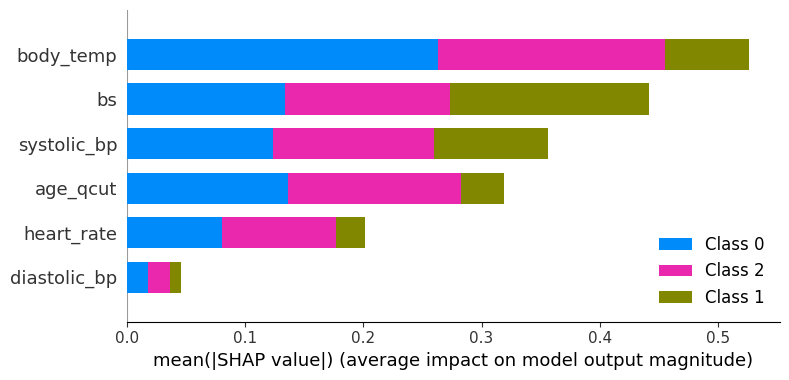

In [38]:
fast_cat(df.drop('age', axis=1), param=cat_param)

Практически все параметры с нормальной значимостью, кроме второй части давления. Но оно немного добавляет точности, можно оставить.

Топ3 важности меняется в зависимости от типа оценки.